## MBA em Ciência de Dados
# Redes Neurais e Aprendizado Profundo

## <span style="color:darkred">Avaliação Final - 2024 : Enuncaido</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `imdb-reviews-pt-br.csv` que contém avaliações de filmes realizadas no site IMDB, com textos em português e em inglês. O alvo do dataset é a coluna `sentiment` que contém o sentimento relacionado à avaliação: positivo ou negativo.

Vamos explorar um sentence embedding pré-treinado para multiplos idiomas, e avaliar redes neurais comparando-as com relação aos textos em inglês e português.

As tarefas a realizar são as seguintes:

Preparação:
1. **Instalar o pacote** `sentence_transformers` e **carregar o modelo** 'stsb-xlm-r-multilingual' para geração de sentence embeddings, conforme mostrado no código abaixo.
2. **Carregar a base de dados** e obter uma amostra de 12 mil linhas (use o método `sample` do dataframe pandas).
3. **Gerar os embeddings** usando o método encode, para os textos em português e em inglês. Ver https://www.sbert.net/examples/applications/computing-embeddings/README.html para mais detalhes. OBS: pode demorar um pouco
4. **Separar dados** 75% para treinamento, 25% para teste usando `train_test_split`, sendo a mesma partição para ingles e portugues.

Modelos:
1.  (1,0 pt) **Modelo A**: projete e treine uma rede neural profunda densa, utilizando como entrada os embeddings pré-treinados dos dados em **portugues** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * normalização em batch
        * densa 768 neurônios, relu
        * densa 512 neurônios, relu
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar Adam com taxa de aprendizado inicial de 0.0007 e com decaimento em todas as épocas exponencial a -0.09
    * Treinar com perda entropia cruzada por 15 épocas com batch size 20
    * Compute como métricas, além da perda, a área sob a curva ROC (AUC ROC) e a Acurácia Binária (ver https://www.tensorflow.org/api_docs/python/tf/keras/metrics)<br><br>

2.  (1,0 pt) **Modelo B**: projete e treine uma rede neural profunda densa, utilizando como entrada os *textos tokenizados* em **português** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * camada embedding com max_words=5000 e dimensão do embedding de tamanho 386
        * camada convolucional 1d com 64 neuronios de tamanho 2 e padding='same', ativação relu
        * camada LSTM 512 neurônios, sem especificar ativação (manter a default)
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar os mesmos hiper-parâmetros de otimização, treinamento e métricas do modelo anterior<br><br>


3. (2,0 pt) **Avalie as rede neurais de classificação** (Modelos A e B):
    * Exiba o gráfico das métricas ROC AUC e Accuracy calculadas no treinamento ao longo das épocas para o modelos A e B
    * Calcule e exiba as métricas no conjunto de teste usando o cada modelo</br>
    3.1 (2,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

4. (3,0 pt) **Fine-tuning** dos Modelo B com os dados em inglês, treinando por 15 épocas e batch_size=20, com Adam e taxa de aprendizado 0.00001 (sem decaimento):
    1. Modelo Fine Tuning versão 1: realize ajuste fino, congelando a camada de embeddings,
    2. Modelo Fine Tuning versão 2: realize ajuste fino, congelando a camada convolucional e a camada LSTM.
        
    * exibir a função de custo ao longo das épocas de treinamento para cada modelo,
    * calcular e exibir métricas dos modelos após fine-tuning usando o conjunto de teste em ingles (textos tokenizados)</br>
    4.1 (1,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

5. **Bônus:** (+1 ponto extra)
    * *Análise visual das características*: visualize scatterplots com os 2 dimensões obtidos com o método tSNE as classes dos exemplos atribuídas com cores ou marcadores diferentes:
        1. scatterplot com projeção tSNE do conjunto de teste referente ao embedding pré-treinado em português,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste tokenizado em português referente ao *Modelo B*,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste em inglês (tokens) referente ao *Modelo B* após ajuste fino versão 2.
    * Escreva comentários com suas conclusões sobre a análise visual.

## Preparação

### 1. Carregar bibliotecas e modelo pré-treinado SentenceTransformer

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from numpy.random import seed

from tensorflow.random import set_seed
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

#### Verifique a versão do Tensorflow, recomendamos a 2.17.
OBS: o código pode ter problemas com a versão 2.18

In [2]:
print(tf.__version__)

2.17.0


In [3]:
# baixar modelo codificador de setenças
model = SentenceTransformer('stsb-xlm-r-multilingual')

### 2. Carregar base de dados e obter amostra

In [4]:
!gdown 1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK

# ler base de dados
df_orig = pd.read_csv("imdb-reviews-pt-br.csv", delimiter=',', engine='python')

zsh:1: command not found: gdown


In [5]:
# obter amostra
df = df_orig.sample(12000).reset_index(drop=True)
df.sentiment.value_counts()

sentiment
pos    6045
neg    5955
Name: count, dtype: int64

### 3. Separar dados em treinamento e teste e preparar rótulos

Iremos também verificar o tamanho das strings em cada instancia, para considerar apenas um número de caracteres proporcional ao percentil 80.

In [6]:
# rotulos
y = np.array((df.sentiment=='pos').astype(int))

X_train_txt_en, X_test_txt_en, y_train_en, y_test_en= train_test_split(df.text_en.values, y, test_size=0.25, random_state=51)
X_train_txt_pt, X_test_txt_pt, y_train_pt, y_test_pt= train_test_split(df.text_pt.values, y, test_size=0.25, random_state=51)

sum(y_train_en!=y_train_pt)

0

In [7]:
# tamanhos das strings - usaremos o percentil 80 como tamanho da entrada máximo
num_words = df.text_pt.apply(lambda x: len(str(x).split()))
max_length = num_words.max()
percentile_80 = num_words.quantile(0.80)
percentile_95 = num_words.quantile(0.95)

print(f"percentil 80.0: {percentile_80}")
print(f"percentil 95.0: {percentile_95}")
print(f"Maximo: {max_length}")

percentil 80.0: 308.0
percentil 95.0: 546.0
Maximo: 955


### 4. Geração dos embeddings

Utilizar o encoder carregado para obter os embeddings para treinamento e teste em Português e Inglês, separadamente.

Exemplo de uso: `model.encode(texto, batch_size=16, show_progress_bar=True)`

In [8]:
#X_train_en = model.encode(X_train_txt_en, batch_size=16, show_progress_bar=True)
# ...
# Obter embeddings para textos em inglês (treinamento e teste)
X_train_en_embeddings = model.encode(X_train_txt_en, batch_size=16, show_progress_bar=True)
X_test_en_embeddings = model.encode(X_test_txt_en, batch_size=16, show_progress_bar=True)

# Obter embeddings para textos em português (treinamento e teste)
X_train_pt_embeddings = model.encode(X_train_txt_pt, batch_size=16, show_progress_bar=True)
X_test_pt_embeddings = model.encode(X_test_txt_pt, batch_size=16, show_progress_bar=True)

# Exibindo as dimensões dos embeddings gerados
print("Dimensões dos embeddings gerados:")
print(f"X_train_en_embeddings: {X_train_en_embeddings.shape}")
print(f"X_test_en_embeddings: {X_test_en_embeddings.shape}")
print(f"X_train_pt_embeddings: {X_train_pt_embeddings.shape}")
print(f"X_test_pt_embeddings: {X_test_pt_embeddings.shape}")

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Dimensões dos embeddings gerados:
X_train_en_embeddings: (9000, 768)
X_test_en_embeddings: (3000, 768)
X_train_pt_embeddings: (9000, 768)
X_test_pt_embeddings: (3000, 768)


5. Tokenização do texto

Definiremos um número máximo de palavras e um tamanho máximo de sequência com base nos dados em Português, conforme abaixo.

In [9]:
max_words = 5000  # Numero maximo de palavras
max_sequence_length = int(percentile_80)  # Tamanho maximo da sequencia igual ao percentil 80

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_txt_pt)

sequences_train = tokenizer.texts_to_sequences(X_train_txt_pt)
sequences_test = tokenizer.texts_to_sequences(X_test_txt_pt)

# realizar padding para igualar sentencas
X_train_tok_pt = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_tok_pt = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [10]:
## realizar o mesmo procedimento para os textos em ingles
# use os mesmos parametros de maximo de palavras e sequencia
max_words = 5000  # Numero maximo de palavras
max_sequence_length = int(percentile_80)  # Tamanho maximo da sequencia igual ao percentil 80

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_txt_en)

sequences_train = tokenizer.texts_to_sequences(X_train_txt_en)
sequences_test = tokenizer.texts_to_sequences(X_test_txt_en)

# realizar padding para igualar sentencas
X_train_tok_en = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_tok_en = pad_sequences(sequences_test, maxlen=max_sequence_length)

---

## Tarefas

Definimos os modelos e iniciamos as tarefas. O código abaixo é uma referência para auxiliar na resolução, complete/altere conforme necessário.

In [11]:
# DICA: use keras.layers.CAMADA para montar as arquiteturas

# definir modelo A
def model_A(input_dim):
    input_data = keras.layers.Input(shape=(input_dim,))
    # ...
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    dnn = keras.models.Model(input_data, output)
    return dnn

In [12]:
# definir modelo B
def model_B(input_dim, max_words, embedding_dim=386, code_dim=256):
    input_layer = keras.layers.Input(shape=(input_dim,))
    embedding_layer = keras.layers.Embedding(max_words, embedding_dim, name='embedding')(input_layer)
    # ...
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
epochs = 15
batch_size = 20
lrate = 0.0007

---

### 1. (1,0 pt) Modelo A: classificador de sentimento em *portugues* usando embedding pré-treinado

In [11]:
seed(1)
set_seed(2)

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.09))

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# instanciar, compilar e treinar modelo A

np.random.seed(1)
tf.random.set_seed(2)

# Definir modelo A
def model_A(input_dim):
    input_data = keras.layers.Input(shape=(input_dim,))

    # Camada de normalização em batch
    x = keras.layers.BatchNormalization()(input_data)

    # Camada densa 1: 768 neurônios, ativação ReLU
    x = keras.layers.Dense(768, activation='relu')(x)

    # Camada densa 2: 512 neurônios, ativação ReLU
    x = keras.layers.Dense(512, activation='relu')(x)

    # Camada densa intermediária: 256 neurônios, ativação linear
    x = keras.layers.Dense(256, activation='linear')(x)

    # Normalização em batch
    x = keras.layers.BatchNormalization()(x)

    # Ativação ReLU
    x = keras.layers.Activation('relu')(x)

    # Dropout
    x = keras.layers.Dropout(0.375)(x)

    # Camada de saída: 1 neurônio, ativação sigmoide
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    # Criar o modelo
    dnn = keras.models.Model(input_data, output)
    return dnn

# Inicializar modelo com dimensão de entrada
input_dim = X_train_pt_embeddings.shape[1]
modelA = model_A(input_dim)

# Compilar modelo
initial_lr = 0.0007
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
modelA.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
)

# Treinar o modelo
historyA = modelA.fit(
    X_train_pt_embeddings, y_train_pt,
    validation_data=(X_test_pt_embeddings, y_test_pt),
    epochs=15,
    batch_size=20,
    callbacks=[callbacklr]
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7282 - auc: 0.8046 - loss: 0.5867 - val_accuracy: 0.7963 - val_auc: 0.8771 - val_loss: 0.4590 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7927 - auc: 0.8730 - loss: 0.4490 - val_accuracy: 0.7947 - val_auc: 0.8789 - val_loss: 0.4494 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8199 - auc: 0.9000 - loss: 0.4006 - val_accuracy: 0.7913 - val_auc: 0.8756 - val_loss: 0.4743 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8456 - auc: 0.9261 - loss: 0.3470 - val_accuracy: 0.7863 - val_auc: 0.8698 - val_loss: 0.5182 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8863 - auc: 0.9543 - loss: 0.2751 - val_accuracy: 0.7787 - val_auc: 0.8618 - val_loss: 0.6157 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accura

---

### 2. (1,0 pt) Modelo B: classificador de sentimento em *português* usando tokenizador e rede CNN+LSTM

In [12]:
seed(1)
set_seed(2)

# instanciar, compilar e treinar modelo B

# Definir as seeds para reprodutibilidade
np.random.seed(1)
tf.random.set_seed(2)

# Definir modelo B
def model_B(max_words, embedding_dim=386):
    input_layer = keras.layers.Input(shape=(None,))

    # Camada de embedding
    embedding_layer = keras.layers.Embedding(max_words, embedding_dim, name='embedding')(input_layer)

    # Camada convolucional 1D
    conv1d_layer = keras.layers.Conv1D(64, kernel_size=2, padding='same', activation='relu')(embedding_layer)

    # Camada LSTM
    lstm_layer = keras.layers.LSTM(512)(conv1d_layer)

    # Camada densa intermediária
    dense_layer = keras.layers.Dense(256, activation='linear')(lstm_layer)

    # Normalização em batch
    batch_norm_layer = keras.layers.BatchNormalization()(dense_layer)

    # Ativação ReLU
    relu_activation = keras.layers.Activation('relu')(batch_norm_layer)

    # Dropout
    dropout_layer = keras.layers.Dropout(0.375)(relu_activation)

    # Camada de saída
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

    # Criar o modelo
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Inicializar o modelo
max_words = 5000
embedding_dim = 386
#input_dim = 305 Testando por conta de erro
modelB = model_B(max_words, embedding_dim)

# Compilar o modelo
initial_lr = 0.0007
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
modelB.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
)

# Definir o scheduler para ajuste de taxa de aprendizado
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.09))

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)



In [13]:
# Treinar o modelo
historyB = modelB.fit(
    X_train_tok_pt, y_train_pt,  
    validation_data=(X_test_tok_pt, y_test_pt),  
    epochs=15,
    batch_size=20,
    callbacks=[callbacklr]
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 311s 690ms/step - accuracy: 0.6576 - auc: 0.7216 - loss: 0.6123 - val_accuracy: 0.5060 - val_auc: 0.5017 - val_loss: 5.6002 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 315s 699ms/step - accuracy: 0.8465 - auc: 0.9240 - loss: 0.3536 - val_accuracy: 0.5047 - val_auc: 0.5007 - val_loss: 9.5075 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 296s 659ms/step - accuracy: 0.9230 - auc: 0.9767 - loss: 0.2042 - val_accuracy: 0.5043 - val_auc: 0.5000 - val_loss: 29.8893 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 292s 648ms/step - accuracy: 0.9604 - auc: 0.9932 - loss: 0.1052 - val_accuracy: 0.6143 - val_auc: 0.7571 - val_loss: 2.6014 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 330s 735ms/step - accuracy: 0.9837 - auc: 0.9972 - loss: 0.0572 - val_accuracy: 0.5040 - val_auc: 0.4997 - val_loss: 28.5863 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━

---

### 3. (2,0 pt) Avaliação dos modelos: métricas durante treinamento e avaliação das métricas no conjunto de teste de ambos os modelos

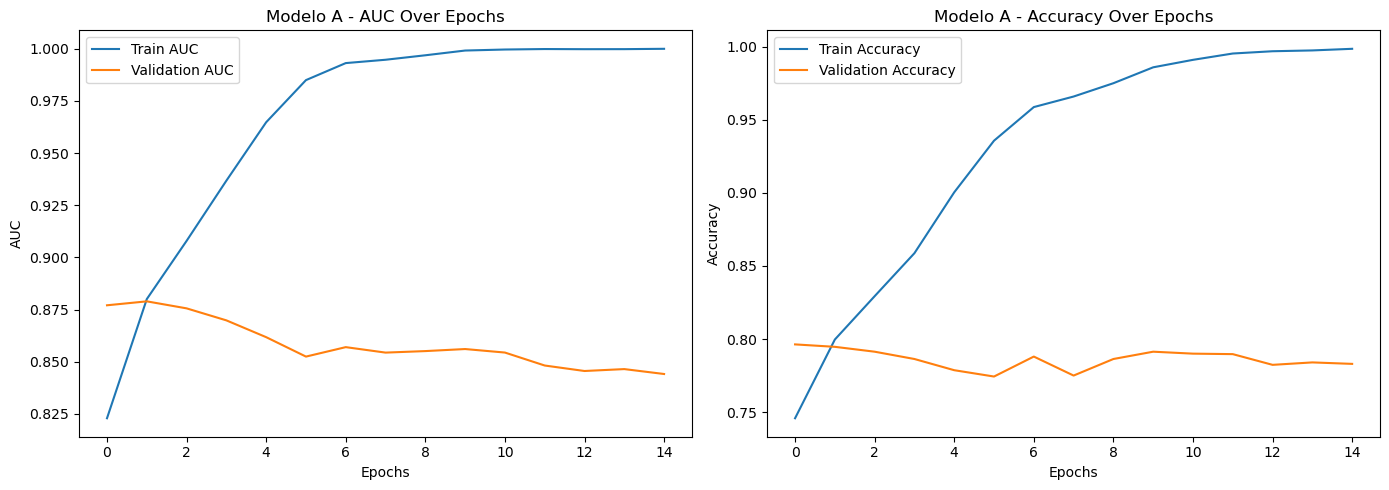

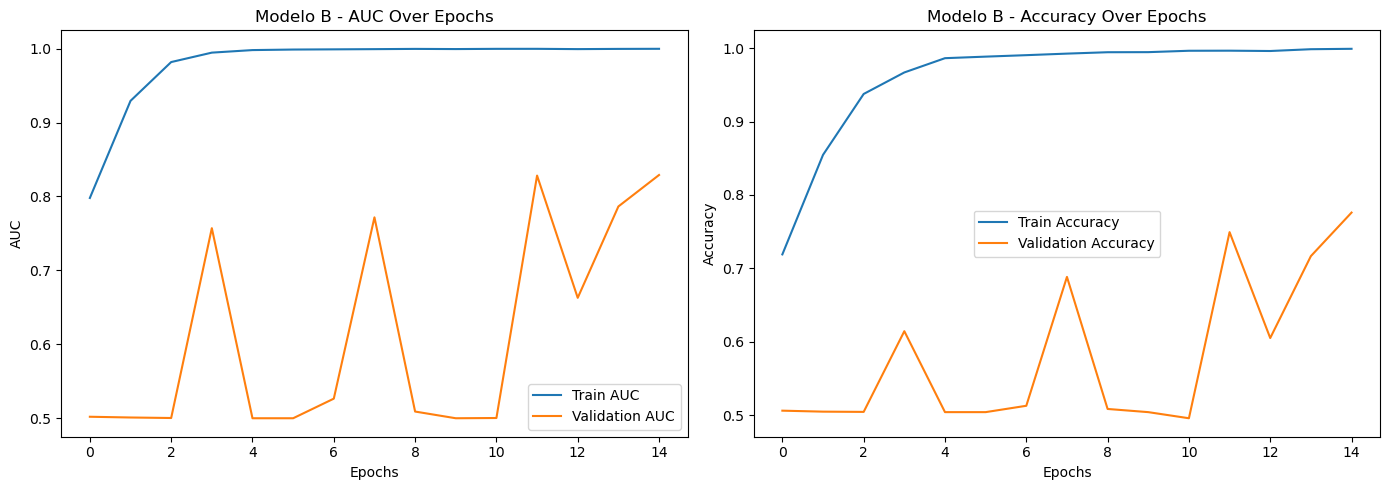

In [14]:
## plot métricas durante treinamento dos modelos A e B
# Função para exibir gráficos de métricas durante o treinamento
def plot_training_metrics(history, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 5))

    # Plotar AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f'{model_name} - AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    # Plotar Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exibir métricas de treinamento para os Modelos A e B
plot_training_metrics(historyA, "Modelo A")
plot_training_metrics(historyB, "Modelo B")


In [15]:
## avaliacao no conjunto de teste dos modelos A e B treinados
# exibir os valores obtidos
# Função para calcular métricas no conjunto de teste
def evaluate_model(model, X_test, y_test, model_name):
    from sklearn.metrics import roc_auc_score, accuracy_score

    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))

    print(f"{model_name} - Test Set Metrics:")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return auc, accuracy

# Avaliar os modelos no conjunto de teste
auc_a, acc_a = evaluate_model(modelA, X_test_pt_embeddings, y_test_pt, "Modelo A")
auc_b, acc_b = evaluate_model(modelB, X_test_tok_pt, y_test_pt, "Modelo B")

# Comparação dos resultados
results = {
    "Modelo": ["Modelo A", "Modelo B"],
    "Test ROC AUC": [auc_a, auc_b],
    "Test Accuracy": [acc_a, acc_b]
}

results_df = pd.DataFrame(results)
print(results_df)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Modelo A - Test Set Metrics:
ROC AUC: 0.8639
Accuracy: 0.7830
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step
Modelo B - Test Set Metrics:
ROC AUC: 0.8927
Accuracy: 0.7760
     Modelo  Test ROC AUC  Test Accuracy
0  Modelo A      0.863904          0.783
1  Modelo B      0.892742          0.776


### 3.1 (2,0 pt) Escreva conclusões sobre a comparação entre os modelos A e B em termos:
- das métricas computadas ao longo do treinamento
- conclua sobre os resultados da generalização dos modelos e relacione esse resultado com a arquitetura de cada modelo (camadas utilizadas e número de parâmetros).

Escreva apenas um parágrafo para cada um dos items acima. As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook.

< suas conclusões aqui >
- **Métricas de treinamento**:
- **Generalização e arquitetura**:

---

### 4. (3,0 pt) Fine-tuning do Modelo B usando os dados em **ingles**

O modelo foi treinado com dados em português e agora queremos realizar transferência de aprendizado, realizando ajuste fino dos parâmetros para que possa classificar texto em inglês.

Serão feitos dois experimentos, ambos a partir dos pesos do modelo B, usando os tokens extraídos dos textos em ingles:

1. Modelo B FT v1: congele a camada de embedding (ou seja setando essa camada como `trainable=False`), e permita que todas as demais possam se adaptar.
2. Modelo B FT v2: congele apenas a camada convolucional e a camada LSTM, e permita que todas as demais (inclusive a camada de embedding, anterior a essas) possam se adaptar.

Após o treinamento compare ambos modelos exibindo:
- um gráfico com a loss ao longo do treinamento
- um gráfico com as métricas obtidas ao longo do treinamento
- as métricas (numéricas) obtidas no conjunto de teste

In [16]:
## Experimentos de Fine-tuning do Modelo B
from tensorflow.keras.models import clone_model

# Função para criar o modelo com pesos congelados
def create_finetune_model(base_model, trainable_layers):
    # Clonar o modelo base para preservar os pesos
    new_model = clone_model(base_model)
    new_model.set_weights(base_model.get_weights())

    # Congelar/descongelar camadas conforme o experimento
    for layer in new_model.layers:
        layer.trainable = layer.name in trainable_layers

    # Compilar o modelo ajustado com learning rate fixo
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
    )
    return new_model


In [17]:
# Cria novo modelo copiando a arquitetura e pesos anteriores
# ajusta camadas a serem treinadas ou congeladas
# realizar finetuning com learning rate fixo = 0.0001
# Experimento 1: Modelo B FT v1
trainable_layers_v1 = {"conv1d", "lstm", "dense", "batch_normalization", "activation", "dropout", "dense_1"}
modelB_FT_v1 = create_finetune_model(modelB, trainable_layers_v1)

# Experimento 2: Modelo B FT v2
trainable_layers_v2 = {"embedding", "dense", "batch_normalization", "activation", "dropout", "dense_1"}
modelB_FT_v2 = create_finetune_model(modelB, trainable_layers_v2)

# Ajuste fino no Modelo B FT v1
history_FT_v1 = modelB_FT_v1.fit(
    X_train_tok_en, y_train_en,  # Tokens e rótulos em inglês
    validation_data=(X_test_tok_en, y_test_en),
    epochs=15,
    batch_size=20
)

# Ajuste fino no Modelo B FT v2
history_FT_v2 = modelB_FT_v2.fit(
    X_train_tok_en, y_train_en,  # Tokens e rótulos em inglês
    validation_data=(X_test_tok_en, y_test_en),
    epochs=15,
    batch_size=20
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 308s 683ms/step - accuracy: 0.5258 - auc: 0.5296 - loss: 1.5194 - val_accuracy: 0.5153 - val_auc: 0.5574 - val_loss: 0.7020
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 296s 657ms/step - accuracy: 0.5305 - auc: 0.5377 - loss: 0.6913 - val_accuracy: 0.5097 - val_auc: 0.5672 - val_loss: 0.6943
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 310s 689ms/step - accuracy: 0.5301 - auc: 0.5483 - loss: 0.6897 - val_accuracy: 0.5130 - val_auc: 0.5797 - val_loss: 0.6919
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 303s 673ms/step - accuracy: 0.5384 - auc: 0.5552 - loss: 0.6882 - val_accuracy: 0.5253 - val_auc: 0.5954 - val_loss: 0.6914
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 311s 691ms/step - accuracy: 0.5451 - auc: 0.5698 - loss: 0.6845 - val_accuracy: 0.5150 - val_auc: 0.6227 - val_loss: 0.6909
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 305s 677ms/step - accuracy: 0.5658 - auc: 0.5943 - loss: 0.8430 - val_accuracy: 0.5993 - val_auc: 0.6258 - val_loss: 1.0087
Epoch 7/15
450/4

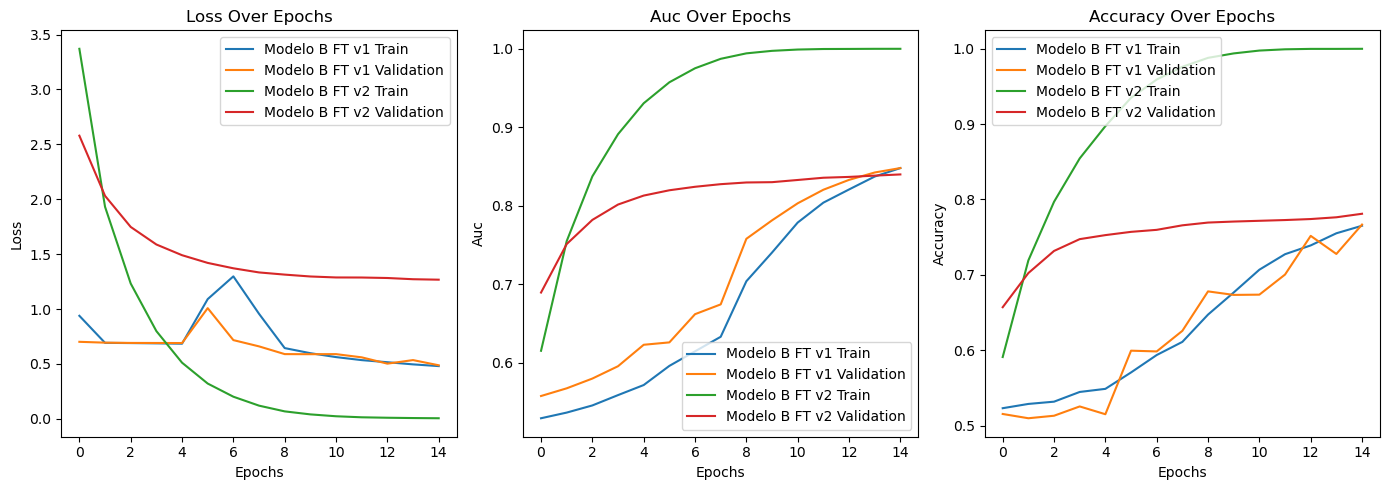

In [18]:
# visualiza loss de treinamento dos modelos

# Função para plotar métricas
import matplotlib.pyplot as plt
def plot_metrics(histories, metrics, labels):
    plt.figure(figsize=(14, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        for history, label in zip(histories, labels):
            plt.plot(history.history[metric], label=f'{label} Train')
            plt.plot(history.history[f'val_{metric}'], label=f'{label} Validation')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

# Plotar gráficos de loss e métricas
plot_metrics(
    histories=[history_FT_v1, history_FT_v2],
    metrics=['loss', 'auc', 'accuracy'],
    labels=['Modelo B FT v1', 'Modelo B FT v2']
)

In [19]:
# visualiza métricas de treinamento dos modelos
# Avaliar os modelos no conjunto de teste
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))
    print(f"{model_name} - Test Set Metrics:")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return auc, accuracy

# Avaliar os modelos
print("\nAvaliação dos Modelos no Conjunto de Teste:")
auc_v1, acc_v1 = evaluate_model(modelB_FT_v1, X_test_tok_en, y_test_en, "Modelo B FT v1")
auc_v2, acc_v2 = evaluate_model(modelB_FT_v2, X_test_tok_en, y_test_en, "Modelo B FT v2")


Avaliação dos Modelos no Conjunto de Teste:
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 310ms/step
Modelo B FT v1 - Test Set Metrics:
ROC AUC: 0.8480
Accuracy: 0.7667
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step
Modelo B FT v2 - Test Set Metrics:
ROC AUC: 0.8595
Accuracy: 0.7810


In [20]:
# avaliacao e comparacao com dados de teste
# Comparação de métricas
results = {
    "Modelo": ["Modelo B FT v1", "Modelo B FT v2"],
    "Test ROC AUC": [auc_v1, auc_v2],
    "Test Accuracy": [acc_v1, acc_v2]
}

results_df = pd.DataFrame(results)
print("\nComparação de Desempenho:")
print(results_df)


Comparação de Desempenho:
           Modelo  Test ROC AUC  Test Accuracy
0  Modelo B FT v1      0.848000       0.766667
1  Modelo B FT v2      0.859525       0.781000


#### 5.1 (1,0 pt) Conclusões sobre o Fine-tuning realizado

Conclua sobre o fine-tuning realizado, comparando os dois modelos abordando:
- a loss e métricas computadas ao longo do treinamento para cada modelo
- as métricas obtidas com os dados de teste
- compare os modelos em termos de sua capacidade de generalização, indicando as razões de terem generalizado melhor ou pior.

As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook. Escreva um ou dois parágrafos com suas conclusões.

_< suas conclusões >_

---
## Bônus (+1pt)

### Análise visual e conclusões

A partir dos espaços de características dos dados de teste usando tSNE em duas dimensões:

a. Espaço embedding original dos dados de teste em portugues,<br>
b. Espaço embedding Modelo B dos dados de teste em português,<br>
c. Espaço embedding Modelo B ajustado para inglês (segunda versão do finetuning) dos dados de teste em ingles.

Tarefas:
1. Plote os espaços projetados em 2D pelo TNSE usando os parametros definidos no exemplo abaixo. Utilize cores e/ou formatos de pontos no gráfico de forma a diferenciar os pontos de cada classe.

2. Escreva um parágrafo com conclusões sobre essa análise visual do espaço embedding/características aprendidas. As conclusões tem que fazer sentido com os plots exibidos.

_<suas conclusões>_

In [21]:
from sklearn.manifold import TSNE

#parametros TSNE
#TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Função para plotar os espaços projetados em 2D com t-SNE
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    # Codificando as labels para usar cores diferentes
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    unique_classes = le.classes_
    
    # Plotando
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_classes):
        idx = encoded_labels == i
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=label, alpha=0.7)
    
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()



In [26]:
modelB.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 386)      │     1,930,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)       │        49,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,880,309 (37.69 MB)

 Trainable params: 3,293,265 (12.56 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,586,532 (25.13 MB)

In [37]:
modelB_FT_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_9 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 386)      │     1,930,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)       │        49,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,153,779 (27.29 MB)

 Trainable params: 1,930,000 (7.36 MB)

 Non-trainable params: 1,363,777 (5.20 MB)

 Optimizer params: 3,860,002 (14.72 MB)

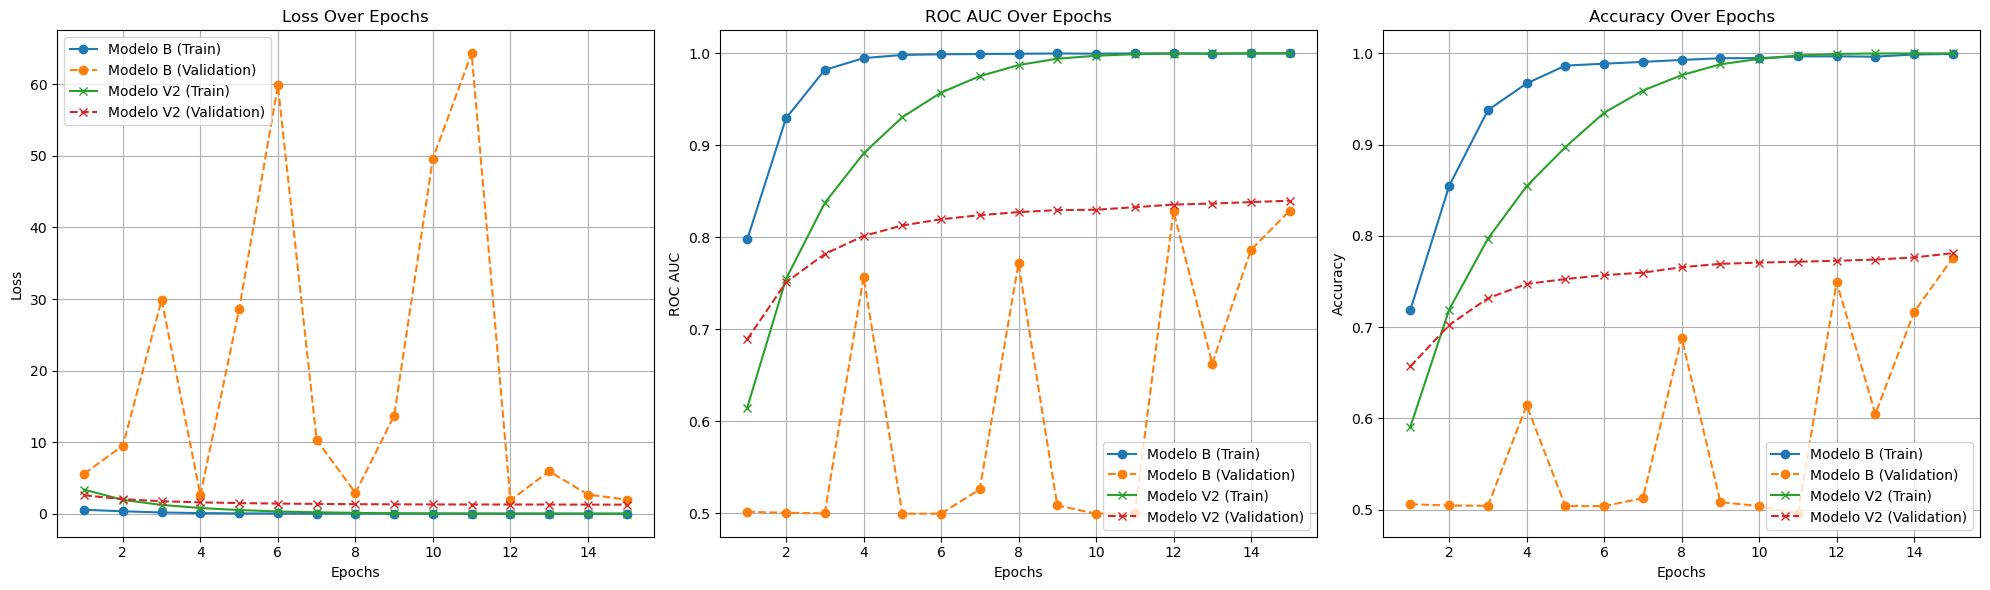

In [41]:
import matplotlib.pyplot as plt

# Extrair os dados reais do histórico do treinamento
history_B = historyB.history 
history_V2 = history_FT_v2.history  

epochs = range(1, len(history_B['loss']) + 1)  # Número de épocas

# Gráficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loss over Epochs
axes[0].plot(epochs, history_B['loss'], label="Modelo B (Train)", marker='o')
axes[0].plot(epochs, history_B['val_loss'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[0].plot(epochs, history_V2['loss'], label="Modelo V2 (Train)", marker='x')
axes[0].plot(epochs, history_V2['val_loss'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ROC AUC over Epochs
axes[1].plot(epochs, history_B['auc'], label="Modelo B (Train)", marker='o')
axes[1].plot(epochs, history_B['val_auc'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[1].plot(epochs, history_V2['auc'], label="Modelo V2 (Train)", marker='x')
axes[1].plot(epochs, history_V2['val_auc'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[1].set_title("ROC AUC Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("ROC AUC")
axes[1].legend()
axes[1].grid(True)

# Accuracy over Epochs
axes[2].plot(epochs, history_B['accuracy'], label="Modelo B (Train)", marker='o')
axes[2].plot(epochs, history_B['val_accuracy'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[2].plot(epochs, history_V2['accuracy'], label="Modelo V2 (Train)", marker='x')
axes[2].plot(epochs, history_V2['val_accuracy'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[2].set_title("Accuracy Over Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Accuracy")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step


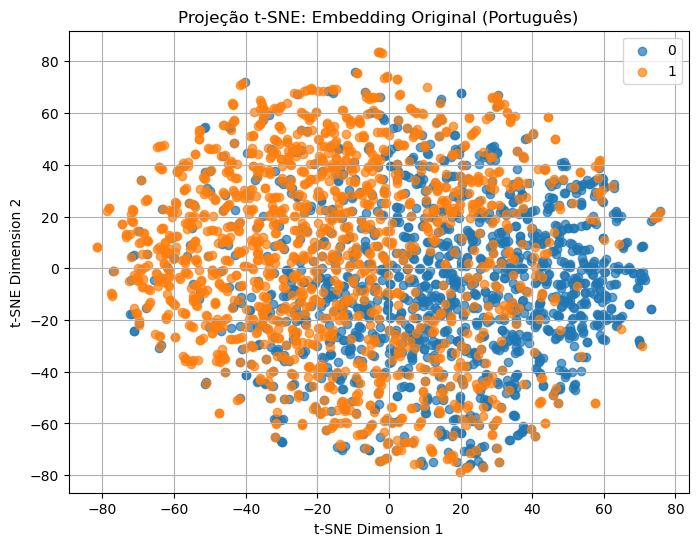

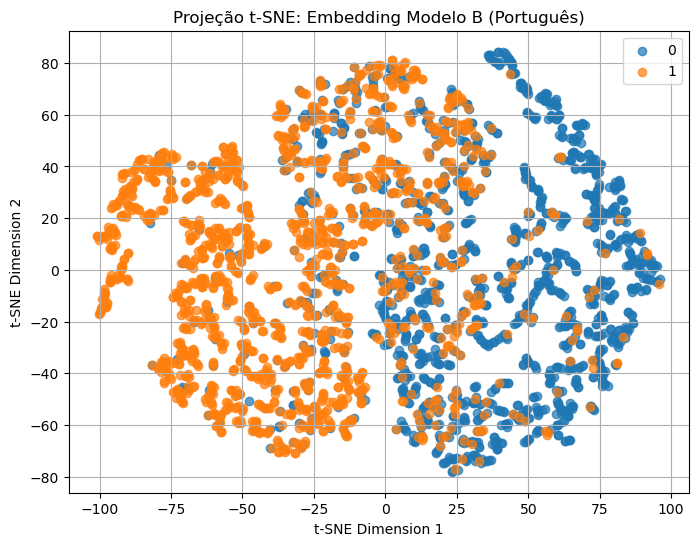

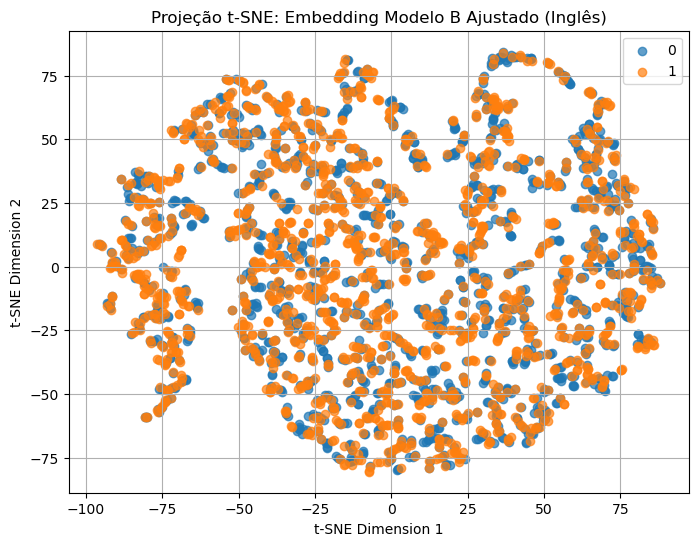

In [44]:
# plot dos espaços em 2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Plotar os embeddings originais (português)
layer_name = 'dense_4' 

# Criar um modelo que retorna a saída da camada desejada
embedding_model = Model(inputs=modelB.input, outputs=modelB.get_layer(layer_name).output)

# Passe os dados de teste para extrair os embeddings
X_test_pt_embeddings_B = embedding_model.predict(X_test_tok_pt)


# Criar um modelo que retorna a saída da camada desejada
embedding_model_V2 = Model(inputs=modelB_FT_v2.input, outputs=modelB_FT_v2.get_layer(layer_name).output)

# Passe os dados de teste para extrair os embeddings
X_test_en_embeddings_B = embedding_model.predict(X_test_tok_en)


scaler = StandardScaler()
X_test_pt_embeddings_B_2d_normalized = scaler.fit_transform(X_test_pt_embeddings_B)
X_test_en_embeddings_B_2d_normalized = scaler.fit_transform(X_test_en_embeddings_B)

# Plotando os gráficos
plot_tsne(X_test_pt_embeddings, y_test_pt, "Projeção t-SNE: Embedding Original (Português)")
plot_tsne(X_test_pt_embeddings_B_2d_normalized, y_test_pt, "Projeção t-SNE: Embedding Modelo B (Português)")
plot_tsne(X_test_en_embeddings_B_2d_normalized, y_test_en, "Projeção t-SNE: Embedding Modelo B Ajustado (Inglês)")
